# 1. Init and add essential libraries

In [1]:
%load_ext tensorboard

In [2]:
!pip install tensorflow matplotlib quickdraw tensorflow-datasets


In [3]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

# 2. Load recognized images from Google's dataset

In [4]:
image_size = (28, 28)

In [5]:
print(QuickDrawData().drawing_names)

['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 

In [6]:
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, 
                                max_drawings=max_drawings, 
                                recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, 
                          max_drawings=1200, 
                          recognized=True)

downloading aircraft carrier from https://storage.googleapis.com/quickdraw_dataset/full/binary/aircraft carrier.bin
download complete
loading aircraft carrier drawings
load complete
downloading airplane from https://storage.googleapis.com/quickdraw_dataset/full/binary/airplane.bin
download complete
loading airplane drawings
load complete
downloading alarm clock from https://storage.googleapis.com/quickdraw_dataset/full/binary/alarm clock.bin
download complete
loading alarm clock drawings
load complete
downloading ambulance from https://storage.googleapis.com/quickdraw_dataset/full/binary/ambulance.bin
download complete
loading ambulance drawings
load complete
downloading angel from https://storage.googleapis.com/quickdraw_dataset/full/binary/angel.bin
download complete
loading angel drawings
load complete
downloading animal migration from https://storage.googleapis.com/quickdraw_dataset/full/binary/animal migration.bin
download complete
loading animal migration drawings
load complete
d

# 3. Create 2 datasets: one for training & one for validation

In [7]:
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=125,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=125,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


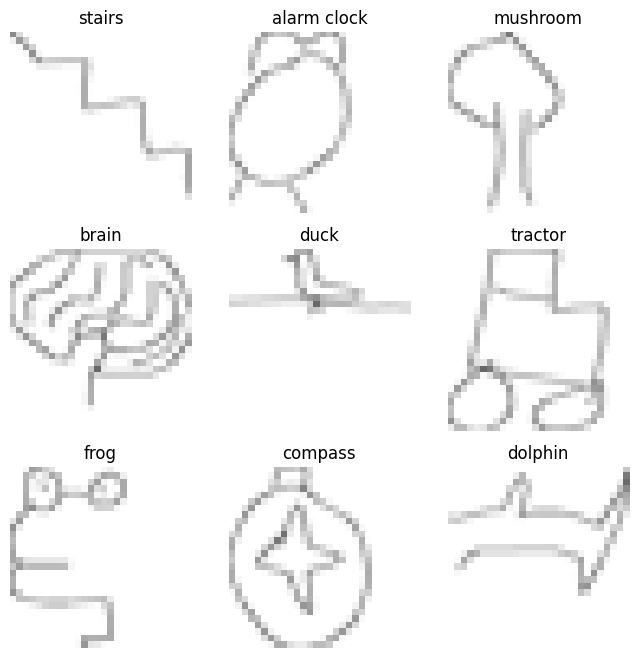

In [8]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

# 4. Create a Convolutional Neural Network

In [9]:
input_shape = (28, 28, 1)
n_classes = 345

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 batch_normalization (Batch  (None, 28, 28, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         60        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         440       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 10)        40        
 chNormalization)                                       

# 5.Training the model

In [10]:
epochs = 7

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/generated_model')

Epoch 1/7
10350/10350 [==============================] - 939s 91ms/step - loss: 2.8882 - accuracy: 0.3319 - val_loss: 2.1445 - val_accuracy: 0.4595
Epoch 2/7
10350/10350 [==============================] - 896s 87ms/step - loss: 2.1533 - accuracy: 0.4594 - val_loss: 1.7300 - val_accuracy: 0.5482
Epoch 3/7
10350/10350 [==============================] - 901s 87ms/step - loss: 1.9127 - accuracy: 0.5069 - val_loss: 1.7803 - val_accuracy: 0.5414
Epoch 4/7
10350/10350 [==============================] - 927s 90ms/step - loss: 1.7742 - accuracy: 0.5375 - val_loss: 1.6518 - val_accuracy: 0.5674
Epoch 5/7
10350/10350 [==============================] - 940s 91ms/step - loss: 1.6817 - accuracy: 0.5562 - val_loss: 1.5602 - val_accuracy: 0.5888
Epoch 6/7
10350/10350 [==============================] - 939s 91ms/step - loss: 1.6117 - accuracy: 0.5709 - val_loss: 1.6400 - val_accuracy: 0.5734
Epoch 7/7
10350/10350 [==============================] - 953s 92ms/step - loss: 1.5584 - accuracy: 0.5823 - val_

# 6. Change TensorFlow model's format to TensorFlow Lite (TFLite) for web implementation

In [13]:
converter = tf.lite.TFLiteConverter.from_saved_model("models/generated_model") # path to the SavedModel directory
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [14]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>